## <a id='toc1_1_'></a>[Import necessary libraries](#toc0_)

In [2]:
import numpy as np
from PIL import Image
import torch
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt

**Table of contents**<a id='toc0_'></a>    
- [Import necessary libraries](#toc1_1_)    
- [Task 1: Simple Image Operations](#toc2_)    
    - [Load image](#toc2_1_1_)    
    - [Print width, height, and number of channels and plot the image](#toc2_1_2_)    
    - [Crop a random patch of size 256x256 from the image](#toc2_1_3_)    
    - [Convert the image patch to grayscale](#toc2_1_4_)    
    - [Insert the grayscale patch back into the original image](#toc2_1_5_)    
    - [Resize the image with the inserted gray patch](#toc2_1_6_)    
- [Task 2: Convolution and Filters](#toc3_)    
    - [Utils](#toc3_1_1_)    
    - [Implement convolution operation](#toc3_1_2_)    
    - [Implement a Gaussian filter](#toc3_1_3_)    
    - [Apply Gaussian filter to image](#toc3_1_4_)    
    - [Implement and apply Laplacian filter to image](#toc3_1_5_)    
    - [Problems with handcrafted filters](#toc3_1_6_)    
      - [Data-Driven Approach](#toc3_1_6_1_)    
      - [Data-Driven Mastery: Enhancing Performance and Generalization](#toc3_1_6_2_)    
- [Task 3: Introduction to PyTorch](#toc4_)    
    - [Convert NumPy array to PyTorch tensor and vice versa](#toc4_1_1_)    
    - [Create a PyTorch convolution operator](#toc4_1_2_)    
    - [Apply Gaussian filter using nn.Conv2d](#toc4_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Task 1: Simple Image Operations](#toc0_)

### <a id='toc2_1_1_'></a>[Load image](#toc0_)

In [2]:
image = Image.open("Capybara.jpg")

### <a id='toc2_1_2_'></a>[Print width, height, and number of channels and plot the image](#toc0_)

In [3]:
width, height = image.size
channels = len(image.getbands())
print(f"{width=} x {height=} x {channels=}")

width=800 x height=600 x channels=3


### <a id='toc2_1_3_'></a>[Crop a random patch of size 256x256 from the image](#toc0_)

In [4]:
cropped_grayscale_patch = image.crop((0,0,256,256))
# Not sure wether you meant randomly taken by _me_ or if the crop has to be
# randomly taken from the machine. In this case I just assumed that random mean _any_
# cropped part of the image.

### <a id='toc2_1_4_'></a>[Convert the image patch to grayscale](#toc0_)

In [5]:
cropped_grayscale_patch = cropped_grayscale_patch.convert(mode="L")

### <a id='toc2_1_5_'></a>[Insert the grayscale patch back into the original image](#toc0_)

In [6]:
image.paste(cropped_grayscale_patch.convert("RGB"))

### <a id='toc2_1_6_'></a>[Resize the image with the inserted gray patch](#toc0_)

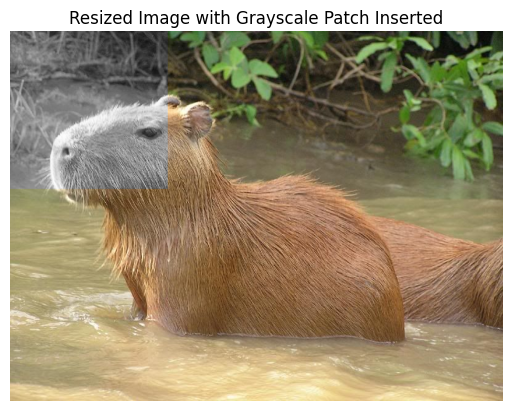

In [7]:
image.resize((width // 2, height // 2))

plt.imshow(image)
plt.title("Resized Image with Grayscale Patch Inserted")
plt.axis('off')
plt.show()

# <a id='toc3_'></a>[Task 2: Convolution and Filters](#toc0_)

### <a id='toc3_1_1_'></a>[Utils](#toc0_)
take care of the range of the value before plot the images

In [4]:
def display_img(x, norm=False):
    """
    Displays image
    """
    x = np.copy(x)
    # Normalize if necessary
    if norm:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # Scale and convert to uint8 format for PIL plotting
    x *= 255
    x = x.astype(np.uint8)
    # Handle channel dimension
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if x.shape[2] == 1:
        x = np.repeat(x, 3, axis=2)

    display(Image.fromarray(x))

def load_img(path, grayscale=False):
    """
    Loads image from given path, converts to float and normalize to [0,1] interval
    """
    img = Image.open(path)
    a = np.asarray(img, dtype=np.float32) / 255
    # Convert to grayscale if necessary
    if grayscale:
        a = np.mean(a, axis=2, keepdims=True)
    return a

### <a id='toc3_1_2_'></a>[Implement convolution operation](#toc0_)

In [9]:
def conv2d(x: np.ndarray, kernel: np.ndarray):
    """
    Performs a 2D convolution operation with a single kernel.

    Args:
        x      (array): the input array of shape (H, W, 1).
        kernel (array): the kernel that is convolved over the input.

    Returns:
        out    (array): the output array.
    """
    height, width, _ = x.shape
    k_height, k_width = kernel.shape

    out_height = height - k_height + 1
    out_width = width - k_width + 1

    out = np.array(
        [[ np.sum(x[i:i+k_height, j:j+k_width, 0] * kernel)
          for j in range(out_width)]
            for i in range(out_height)]
    )
    # I just wanted to write it as a one-liner but
    # unfortunately I feel like it's less clear than the original `for` loops.

    return out

### <a id='toc3_1_3_'></a>[Implement a Gaussian filter](#toc0_)

Gaussian filter:


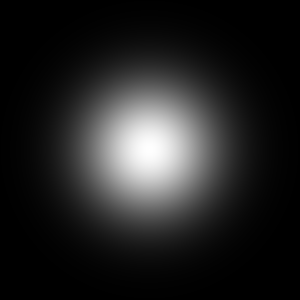

In [16]:
def gaussian_filter(size, mean=0, var=1):
    """
    Returns an isotropic Gaussian filter with.

    Args:
        size       (int): the size of the kernel.
        mean (float/int): the mean of the Gaussian.
        var  (float/int): the variance of the Gaussian.

    Returns:
        f        (array): the Gaussian filter of shape (size, size, 1).
    """
    range = np.arange(-size // 2 + 1, size // 2 + 1)

    x, y = np.meshgrid(range - mean, range - mean)

    f = np.exp(-(x**2+y**2)/(2*var))    # formula from the PDF assignment
    f /= np.sum(f)                      # normalization

    return f

f = gaussian_filter(size=300, mean=0, var=2000)
print('Gaussian filter:')
display_img(f, norm=True)


### <a id='toc3_1_4_'></a>[Apply Gaussian filter to image](#toc0_)

In [11]:
array = load_img("Capybara.jpg", grayscale=True)


Original image:


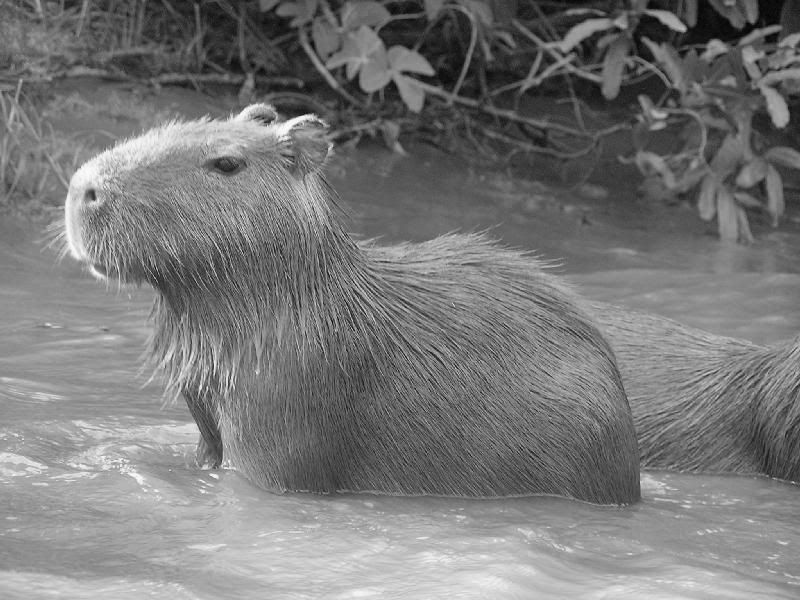

Gaussian filtered image:


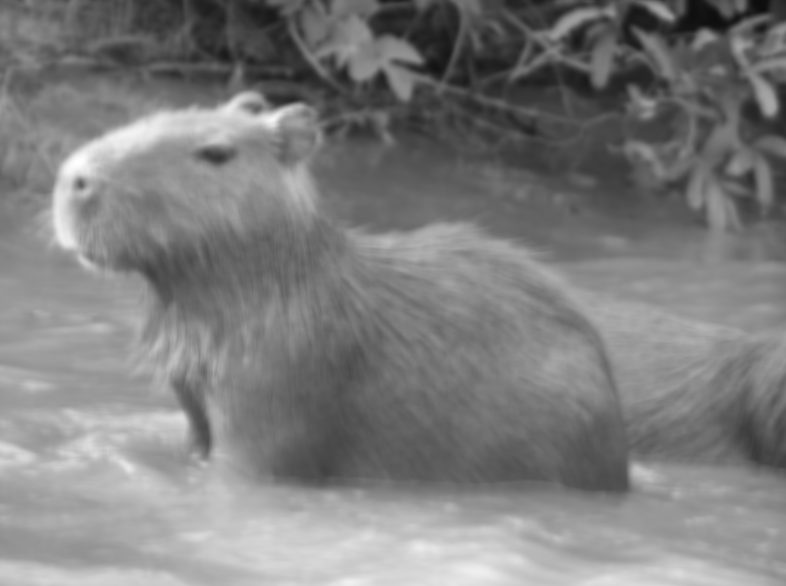

In [12]:
print('Original image:')
display_img(array)
print('Gaussian filtered image:')
gaussian_kernel = gaussian_filter(15, mean=5, var=15)
blurred_img = conv2d(array, gaussian_kernel)
array_filtered_task2 = blurred_img / np.max(blurred_img)
display_img(array_filtered_task2)

### <a id='toc3_1_5_'></a>[Implement and apply Laplacian filter to image](#toc0_)

Hint: If you only apply laplacian and use plt to plot without taking care of the value range, you would probably have a hard time to see something

Original image:


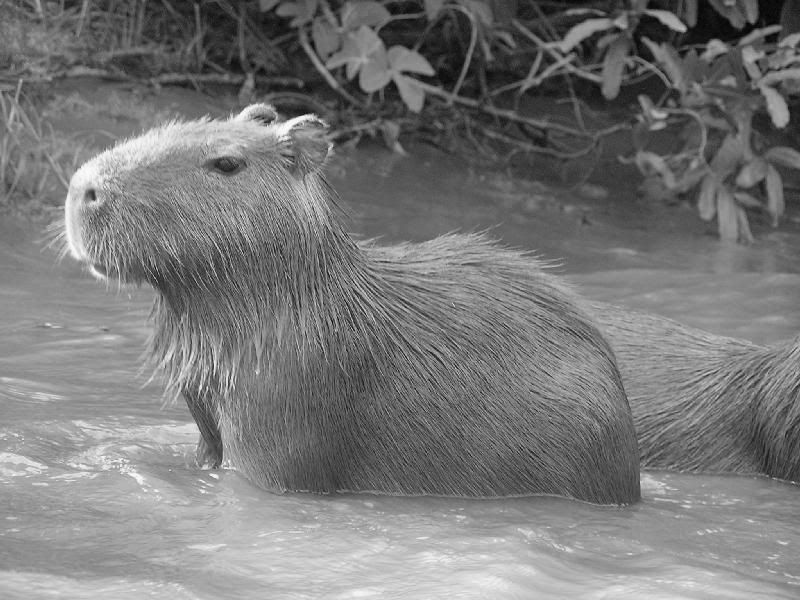

Laplacian filtered image:


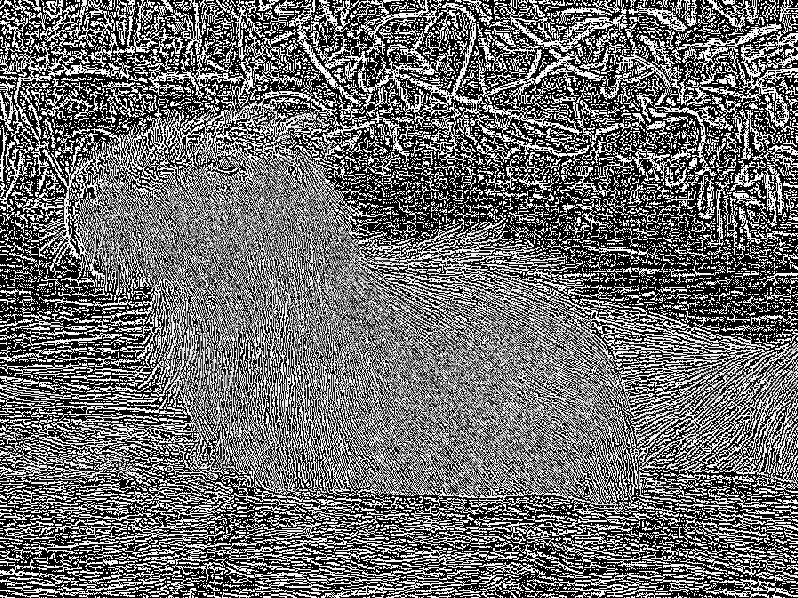

In [13]:
def laplace_filter():
    """
    Returns an isotropic **Laplace** filter with.

    Returns:
        f        (array): the Laplace filter of shape (size, size, 1).
    """

    # Laplacian Kerenel
    # Source: Wikipedia
    laplacian_kernel = np.array([[0, 1, 0],
                                [1, -4, 1],
                                [0, 1, 0]])

    return laplacian_kernel

print('Original image:')
display_img(array)
print('Laplacian filtered image:')
laplace_kernel = laplace_filter()
blurred_img = conv2d(array, laplace_kernel)
array_filtered = blurred_img / np.max(blurred_img)
display_img(array_filtered)

### <a id='toc3_1_6_'></a>[Problems with handcrafted filters](#toc0_)

Manually constructing image filters demands specialized expertise, limiting their adaptability across datasets.

#### <a id='toc3_1_6_1_'></a>[Data-Driven Approach](#toc0_)
In contrast, deep learning empowers models to autonomously learn filters from data, tailoring them to diverse tasks and datasets.

#### <a id='toc3_1_6_2_'></a>[Data-Driven Mastery: Enhancing Performance and Generalization](#toc0_)
This data-driven approach, utilizing vast datasets and intricate learning algorithms, can yield superior performance and generalization.

# <a id='toc4_'></a>[Task 3: Introduction to PyTorch](#toc0_)

### <a id='toc4_1_1_'></a>[Convert NumPy array to PyTorch tensor and vice versa](#toc0_)

In [14]:
image = np.array(Image.open("Capybara.jpg"))
print(image.shape)

image = torch.tensor(image)
print(image.shape)
image = image.swapaxes(0, 2)
print(image.shape)
image = image.swapaxes(0, 2)
print(image.shape)

image = np.array(image)
image = Image.fromarray(image)
image.save("Capybara_copy.jpg")

(600, 800, 3)
torch.Size([600, 800, 3])
torch.Size([3, 800, 600])
torch.Size([600, 800, 3])


In [15]:
def plot_side_by_side(image1, image2):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title("Benchmark Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title("Image of Interest (Supposedly the same)")
    plt.axis('off')

    plt.show()

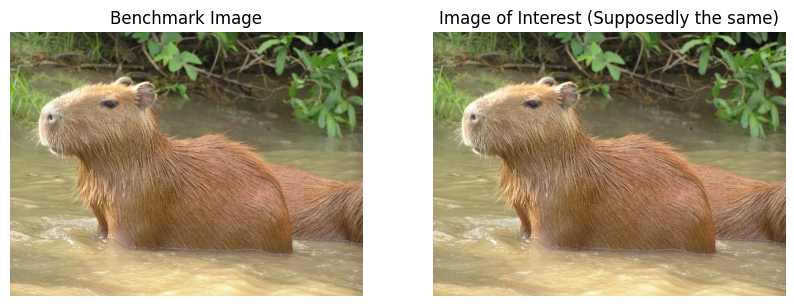

In [16]:
original_image = load_img("Capybara.jpg")
copied_image = load_img("Capybara_copy.jpg")
plot_side_by_side(original_image, copied_image)

### <a id='toc4_1_2_'></a>[Create a PyTorch convolution operator](#toc0_)

In [17]:
x = np.random.rand(5, 5, 1) # image
w = np.random.rand(2, 2, 1) # kernel

conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, bias=False)


# First dimension is the number of kernels that will be applied to the image = 1
# the second dimension is the number of image channels = 1
# and the last two dimensions represent the kernel size = 2 x 2
print(conv.weight.shape)

torch.Size([1, 1, 2, 2])


In [18]:
xt, wt = torch.tensor(x), torch.tensor(w)

xt, wt = xt.swapaxes(0, 2), wt.swapaxes(0, 2)

xt, wt = xt.unsqueeze(0), wt.unsqueeze(0)

conv.weight = torch.nn.Parameter(wt)

out = conv(xt)
print(out)
print(out.shape)

tensor([[[[0.8270, 0.8801, 1.5958, 1.4330],
          [1.4194, 1.7316, 1.0132, 0.8133],
          [1.6388, 0.8424, 0.7724, 0.6794],
          [0.8515, 1.2039, 1.1791, 0.8052]]]], dtype=torch.float64,
       grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 4, 4])


In [19]:
conv2d_perso_out = conv2d(x, w.squeeze(2)).transpose()

print(
    f"Same up to 3 or 4 decimal places --> {np.allclose(conv2d_perso_out, out.detach().numpy(), atol=1e-3)}"
)

Same up to 3 or 4 decimal places --> True


### <a id='toc4_1_3_'></a>[Apply Gaussian filter using nn.Conv2d](#toc0_)

Original image:


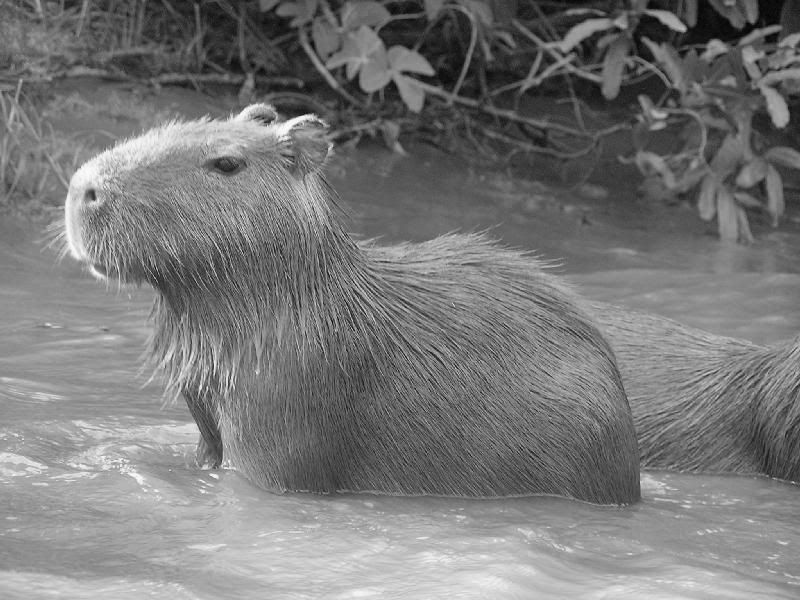

Filtered image:


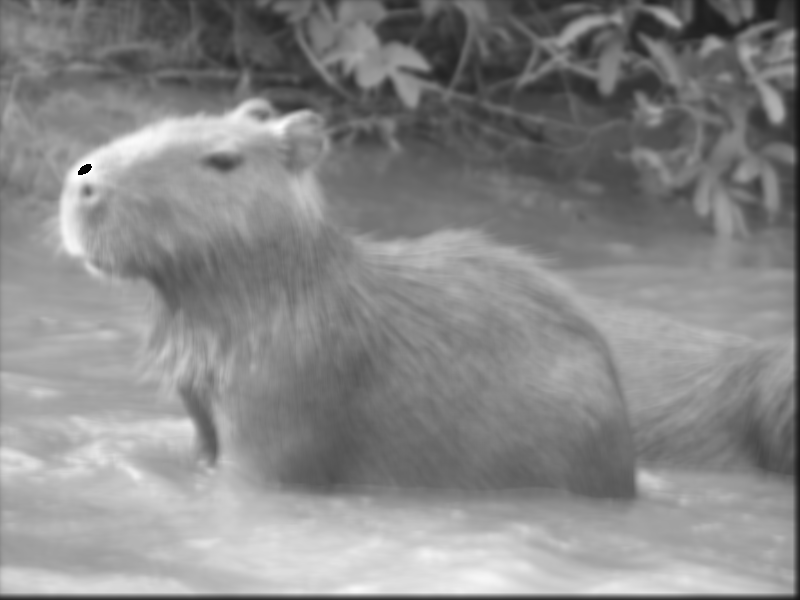

In [20]:
original = load_img("Capybara.jpg", grayscale=True)

x = torch.tensor(original).swapaxes(0,2)
gaussian_kernel_tensor = torch.tensor(gaussian_kernel, dtype=torch.float32)

another_conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=15, padding=15 // 2)
another_conv.weight.data = gaussian_kernel_tensor.unsqueeze(0).unsqueeze(0)

output = another_conv(x)

modified = output.swapaxes(0,2).detach().numpy()
print('Original image:')
display_img(original)
print('Filtered image:')
display_img(modified)

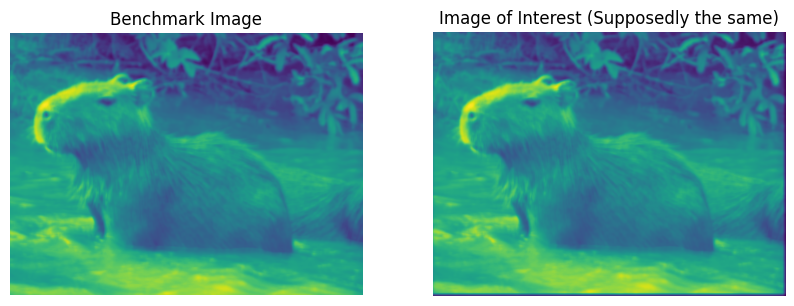

In [21]:
plot_side_by_side(array_filtered_task2, modified)